In [51]:
import sys
import os
import numpy as np
import pandas as pd
from scipy.spatial import distance_matrix
from typing import List
import matplotlib.pyplot as plt
import math
import time
sys.path.insert(1, '../utils')
from utils import *
from utils import plot_solution, greedy_2_regret_weighted, score, get_random_solution
from typing import Callable, Tuple
from abc import ABC, abstractmethod
from sortedcontainers import SortedList
import random
import numba

In [52]:
a=pd.read_csv('../data/TSPA.csv', sep=';', header=None)
b=pd.read_csv('../data/TSPB.csv', sep=';', header=None)
tspa=pd.DataFrame(data=a.values, columns=['x', 'y', 'val'])
tspb=pd.DataFrame(data=b.values, columns=['x', 'y', 'val'])
coordinates=tspa[['x', 'y']].values
coordinatesb=tspb[['x', 'y']].values
dist=distance_matrix(coordinates, coordinates)
dist=np.round(dist)
distb=distance_matrix(coordinatesb, coordinatesb)
distb=np.round(distb)
costs=tspa[['val']].values
costsb=tspb[['val']].values

In [53]:
class Neighborhood(ABC):
    @abstractmethod
    def neighborhood_size(self):
        pass

    @abstractmethod
    def get_difference(self, ind, solution: List[int], unselected):
        pass

    @abstractmethod
    def modify_solution(self, ind, solution: List[int], unselected):
        pass


In [54]:
class EdgeNeighborhood(Neighborhood):
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.distance_matrix = distance_matrix
        self.costs = costs
        self.indexes = list()
        for i in range(1, n-1):
            m = n - 1 if i == 1 else n
            for j in range(i+1, m):
                self.indexes.append((i,j))
        self.indexes=np.array(self.indexes)
        self.size=len(self.indexes)
    def neighborhood_size(self):
        return self.size
    def batch_get_differences(self, solution: List[int], unselected: SortedList, indexes=None):
        n = 100
        
        indexes = self.indexes
        i_vals, j_vals = indexes[:, 0], indexes[:, 1]
        s=np.array(solution)
        i1 = s[(i_vals - 1) % n]
        i2 = s[i_vals]
        j1 = s[j_vals]
        j2 = s[(j_vals + 1) % n]
        return -self.distance_matrix[i1, i2] - self.distance_matrix[j1, j2] \
            + self.distance_matrix[i1, j1] + self.distance_matrix[i2, j2]
    def get_difference(self, ind, solution: List[int], unselected: SortedList):
        n = 100
        i, j = self.indexes[ind]

        i1 = solution[i - 1]
        i2 = solution[i]

        j1 = solution[j]
        j2 = solution[(j + 1)%n]

        return -self.distance_matrix[i1, i2] - self.distance_matrix[j1, j2] \
            + self.distance_matrix[i1, j1] + self.distance_matrix[i2, j2]
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        solution[i:j+1] = solution[j:i-1:-1]
        return solution
    def get_affected_indexes(self, ind, solution: List[int]) -> List[int]:
        i, j = self.indexes[ind]
        start = i - 1
        end = j + 2
        reversed_segment = set(range(start, end)) 
        affected = set()
        for k, (x, y) in enumerate(self.indexes):
            if x in reversed_segment or y in reversed_segment:
                affected.add(k)

        return list(affected)

    
class InterNeighborhood(Neighborhood):
    def __init__(self, distance_matrix: np.ndarray, costs: np.ndarray, n) -> None:
        self.dist_mat = (distance_matrix+costs).T
        self.indexes = list()
        m = len(self.dist_mat) - n
        for i in range(n):
            for j in range(m):
                self.indexes.append((i,j))
        self.indexes=np.array(self.indexes)

        self.size=len(self.indexes)
    def neighborhood_size(self):
        return self.size
    def batch_get_differences(self, solution: List[int], unselected_list: List[int], indexes=None):
        if indexes is None:
            indexes = np.arange(len(self.indexes)) 
        n = 100
        selected_indexes = self.indexes[indexes]
        indices_i, indices_j = selected_indexes[:, 0], selected_indexes[:, 1]
        i_prev = (indices_i - 1) % n
        i_next = (indices_i + 1) % n
        s=np.array(solution)
        u=np.array(unselected_list)
        node_prev = s[i_prev]
        node_current =s[indices_i]  
        node_next = s[i_next]
        node_unselected = u[indices_j]
        differences = (
            -self.dist_mat[node_prev, node_current]
            - self.dist_mat[node_current, node_next]
            + self.dist_mat[node_prev, node_unselected]
            + self.dist_mat[node_unselected, node_next]
        )
        return differences
    def get_difference(self, ind, solution: List[int], unselected):
        n = len(solution)
        i, j = self.indexes[ind]
        i1 = solution[(i-1)%n]
        i2 = solution[i]
        i3 = solution[(i+1)%n]

        j1 = unselected[j]

        return -self.dist_mat[i1, i2] -self.dist_mat[i2, i3] + self.dist_mat[i1, j1] + self.dist_mat[j1, i3]
    
    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        i, j = self.indexes[ind]
        current_node = solution[i]
        solution[i] = unselected[j]
        unselected.remove(unselected[j])
        unselected.add(current_node)
        return solution
    def get_affected_indexes(self, ind, solution: List[int]) -> List[int]:
        i, j = self.indexes[ind]
        n = len(solution)
        adjacent_indices = { (i - 1) % n, (i + 1) % n, i }
        affected = set()
        for k, (x, y) in enumerate(self.indexes):
            if x in adjacent_indices or y in adjacent_indices:
                affected.add(k)
            if y == j:
                affected.add(k)
        
        return list(affected)

class CombinedNeighborhood(Neighborhood):
    def __init__(self , neighborhoods: List[Neighborhood]) -> None:
        self.neighborhoods = neighborhoods
     
        self.offsets = np.cumsum([0] + [n.neighborhood_size() for n in neighborhoods])
        self.size = self.offsets[-1]
        self.indexes = np.concatenate(
            [n.indexes for  n in neighborhoods]
        )
    def neighborhood_size(self):
        return self.size
    def batch_get_differences(self, solution: List[int], unselected: SortedList, indexes=None):
        if indexes is None:
            differences = []
            for neighborhood in self.neighborhoods:
                differences.append(neighborhood.batch_get_differences(solution, unselected))
            return np.concatenate(differences)
        else:
            differences = []
            idx=0
            
            id1=0
            for neighborhood in self.neighborhoods:
                idx+=neighborhood.size
                idxs=np.array(indexes)
                idxs=idxs[idxs>id1]
                idxs=idxs[idxs<idx] 
                idxs=idxs-id1
                differences.append(neighborhood.batch_get_differences(solution, unselected, idxs))
                id1+=idx
            return np.concatenate(differences)
    def get_difference(self, ind, solution: List[int], unselected):
        for neighborhood in self.neighborhoods:
            size = neighborhood.neighborhood_size()
            if ind < size:
                return neighborhood.get_difference(ind, solution, unselected)
            ind -= size

    def modify_solution(self, ind, solution: List[int], unselected: SortedList):
        for neighborhood in self.neighborhoods:
            size = neighborhood.neighborhood_size()
            if ind < size:
                return neighborhood.modify_solution(ind, solution, unselected)
            ind -= size
    def get_affected_indexes(self, ind, solution: List[int]) -> List[int]:
            size=self.neighborhoods[0].neighborhood_size()
            if ind < size:
                return self.neighborhoods[0].get_affected_indexes(ind, solution)
            else:
                ind-=size
                return [x+size for x in self.neighborhoods[1].get_affected_indexes(ind, solution)]
            

In [55]:
def steepest(starting_solution: List[int], distance_matrix: np.ndarray, costs: np.ndarray, neighborhood: Neighborhood) -> list:
    unselected = SortedList(range(len(costs)))
    for i in starting_solution:
        unselected.remove(i)

    solution = starting_solution.copy()

    while True:
        objective_changes = neighborhood.batch_get_differences(solution, unselected)
        best_index = np.argmin(objective_changes)
    
        if objective_changes[best_index] >= 0:
            return solution
    
        solution = neighborhood.modify_solution(best_index, solution, unselected)


In [56]:
def msls( distance_matrix, costs, neighborhood,number_of_iterations=200):
    solutions=[get_random_solution(200) for x in range(number_of_iterations)]
    best_fit=999999999
    best_sol=None
    for sol in solutions:
        s=steepest(sol, dist, costs, neighborhood)
        if score(s, distance_matrix, costs) < best_fit:
            best_fit=score(s, distance_matrix, costs)
            best_sol=s
    return best_sol

In [57]:
def ils(pert_f, distance_matrix, costs, neighborhood):
    x=get_random_solution(200)
    best_fit=999999999
    best_sol=None
    start_time=time.time()
    i=0
    previous_score=score(x, distance_matrix, costs)
    while time.time()-start_time<25:
        y=x.copy()
        for function in pert_f:
            function(y)
        
        y=steepest(y, dist, costs, neighborhood)
      
        scor=score(y, distance_matrix, costs)
        if scor<previous_score:
            x=y
        i+=1
        if  scor< best_fit:
            best_fit=scor
            best_sol=y
    return best_sol, i

In [58]:
n = 200
interNeighborhood = InterNeighborhood(dist, costs, n // 2)
edgeNeighborhood = EdgeNeighborhood(dist, costs, n // 2)
neighborhood = CombinedNeighborhood([edgeNeighborhood, interNeighborhood])


In [64]:
def rswap(sol):
    i=np.random.randint(0,90)
    j=i+10

    tmp=sol[i]
    sol[i]=sol[j]
    sol[j]=tmp

def swich(sol):
    a=np.random.randint(0,100)
    node=sol[a]
    u=[x for x in range(200) if x not in sol]
    d=distb[node, u]
    m=np.argmin(d)
    sol[a]=u[m]
 
def shuff(sol):
    i=np.random.randint(0,90)
    j=i+10

    s=sol[i:j]
    np.random.shuffle(s)
    sol[i:j]=s
  
    
def invert(sol):
    i=np.random.randint(0,90)
    j=i+10
    sol[i:j]=sol[i:j][::-1]
    

In [66]:
def test_method(Neighborhood: CombinedNeighborhood, dists, cost, coordinate, pert_f,name='',):
    scores_2=[]
    sols_2=[]
    times = list()
    i1=[]
    for x in range(20):
        begin_time = time.time()
        if len(pert_f)==0:
            solution_2=msls( dists, cost, Neighborhood)
        else:
            solution_2, i=ils(pert_f, dists, cost, Neighborhood)
            i1.append(i)
        times.append(time.time() - begin_time)

        solution_2 = [int(e) for e in solution_2]
        sols_2.append(solution_2)
        scores_2.append(score(solution_2, dists, cost))   
    print('scores: ', min(scores_2), sum(scores_2)/len(scores_2), max(scores_2))
    print(sols_2[scores_2.index(min(scores_2))])
    print(f'execution time: {min(times)} {sum(times)/len(times)} {max(times)}')
    if len(i1)>0:
        print(f'ils iterations: ', min(i1), sum(i1)/len(i1), max(i1))
    plot_solution(sols_2[scores_2.index(min(scores_2))], coordinate, cost, f'best solution for {name}')

In [61]:
n = 200
interNeighborhood = InterNeighborhood(dist, costs, n // 2)
edgeNeighborhood = EdgeNeighborhood(dist, costs, n // 2)
neighborhood = CombinedNeighborhood([edgeNeighborhood, interNeighborhood])

In [62]:
from itertools import combinations
p=[swich, invert, shuff, rswap]
all_combinations = []
for r in range(len(p) + 1): 
    all_combinations.extend(combinations(p, r))
all_combinations = [list(combo) for combo in all_combinations]



scores:  70807 71393.35 71880
[78, 145, 179, 52, 55, 57, 92, 129, 25, 44, 120, 2, 152, 97, 1, 101, 75, 86, 26, 100, 53, 180, 154, 135, 70, 127, 123, 162, 151, 133, 79, 122, 63, 94, 80, 176, 51, 118, 59, 115, 5, 42, 43, 116, 65, 149, 131, 184, 10, 177, 54, 48, 160, 34, 181, 146, 22, 159, 193, 41, 139, 198, 46, 68, 18, 108, 140, 93, 117, 0, 143, 183, 89, 23, 137, 186, 114, 15, 148, 9, 62, 102, 144, 14, 49, 178, 106, 185, 40, 119, 165, 27, 90, 81, 196, 113, 175, 171, 16, 31]
execution time: 23.34385323524475 24.800985872745514 25.466140508651733


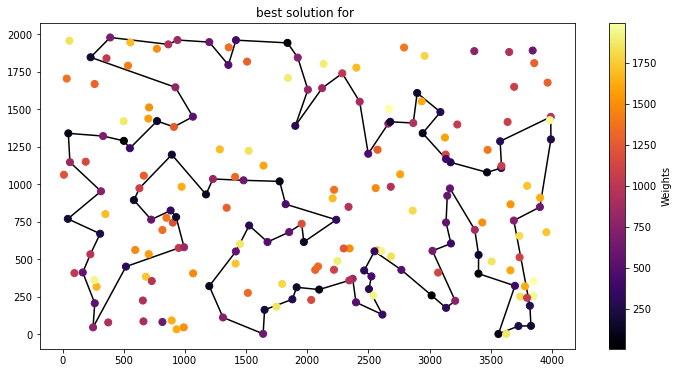

scores:  71546 73667.8 76972
[180, 154, 135, 70, 127, 112, 35, 84, 4, 190, 10, 177, 54, 48, 184, 43, 42, 181, 160, 34, 146, 22, 18, 108, 69, 159, 193, 41, 139, 140, 93, 117, 170, 143, 183, 89, 186, 23, 137, 0, 68, 46, 115, 116, 65, 131, 149, 123, 162, 133, 151, 59, 118, 51, 176, 80, 79, 63, 94, 124, 148, 9, 62, 102, 144, 14, 49, 178, 106, 165, 90, 40, 185, 52, 55, 57, 92, 179, 145, 78, 31, 113, 175, 171, 16, 25, 44, 120, 129, 2, 152, 97, 1, 101, 75, 86, 26, 100, 121, 53]
execution time: 25.000153303146362 25.00136708021164 25.00259256362915
ils iterations:  10512 10781.35 10945


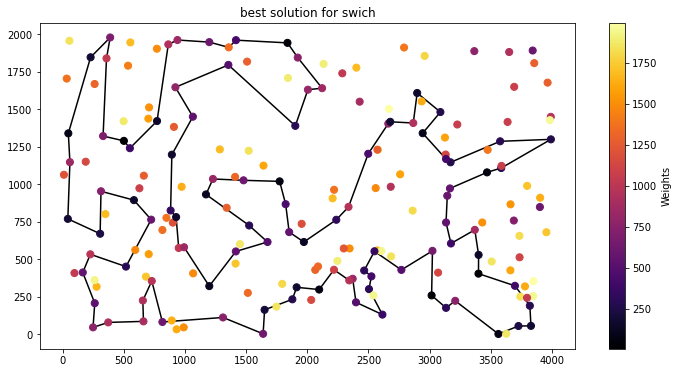

scores:  71876 73441.95 75167
[78, 92, 57, 55, 52, 106, 178, 3, 14, 144, 49, 102, 62, 9, 15, 148, 124, 94, 63, 122, 79, 133, 162, 151, 51, 80, 176, 137, 183, 143, 0, 117, 93, 108, 18, 22, 146, 34, 160, 48, 54, 177, 10, 184, 43, 42, 181, 159, 193, 41, 139, 46, 115, 59, 116, 65, 47, 131, 149, 123, 127, 70, 135, 154, 180, 158, 53, 121, 100, 26, 86, 75, 101, 1, 97, 152, 2, 129, 82, 120, 44, 25, 16, 171, 175, 113, 56, 31, 157, 196, 81, 90, 27, 164, 39, 165, 40, 185, 179, 145]
execution time: 25.000133991241455 25.000979232788087 25.002804279327393
ils iterations:  11228 11380.0 11548


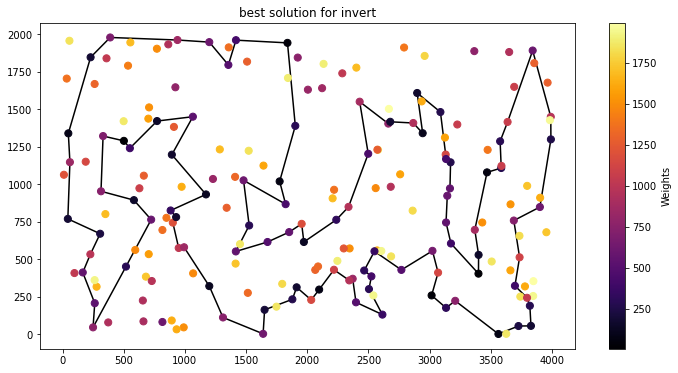

scores:  69432 69764.55 70176
[165, 119, 40, 185, 55, 52, 106, 178, 3, 14, 144, 49, 102, 62, 9, 148, 124, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 140, 108, 18, 22, 146, 159, 193, 41, 139, 46, 115, 5, 42, 181, 34, 160, 48, 54, 177, 10, 190, 4, 112, 84, 184, 43, 116, 65, 149, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 100, 26, 86, 75, 101, 1, 97, 152, 2, 129, 92, 57, 179, 145, 78, 120, 44, 25, 16, 171, 175, 113, 56, 31, 196, 81, 90]
execution time: 25.00014877319336 25.003321886062622 25.00858998298645
ils iterations:  3145 3353.7 3465


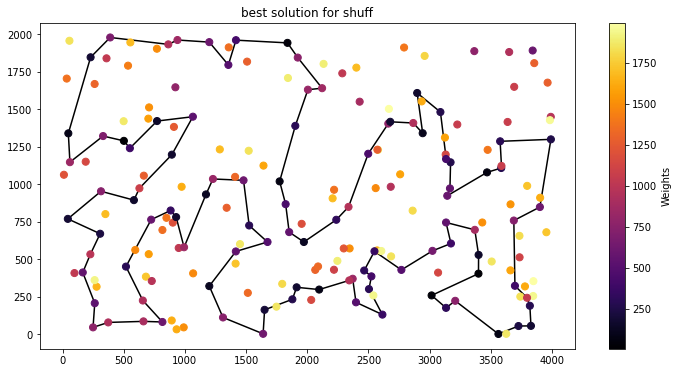

scores:  71154 72811.85 74604
[184, 84, 112, 127, 135, 154, 180, 53, 100, 26, 86, 75, 101, 1, 97, 152, 2, 129, 92, 57, 179, 145, 78, 120, 44, 25, 16, 171, 175, 113, 31, 157, 196, 81, 90, 27, 39, 165, 119, 40, 185, 55, 52, 106, 178, 3, 138, 14, 144, 49, 102, 62, 9, 15, 148, 124, 94, 63, 79, 80, 133, 151, 162, 123, 149, 131, 65, 116, 43, 115, 59, 118, 51, 176, 137, 89, 183, 143, 0, 117, 93, 140, 68, 46, 139, 69, 108, 18, 22, 146, 159, 193, 41, 42, 181, 34, 160, 48, 54, 177]
execution time: 25.000078678131104 25.001983547210692 25.003613710403442
ils iterations:  7374 7714.75 7958


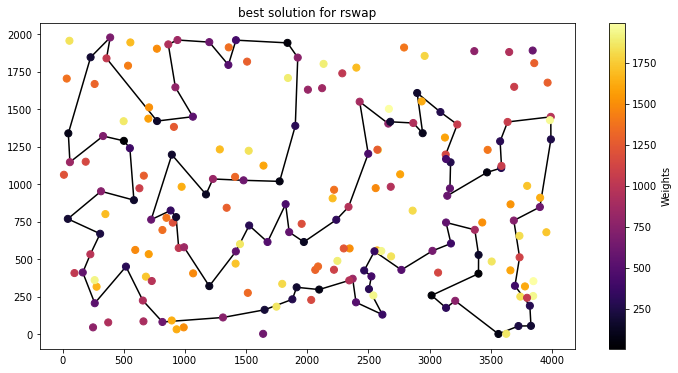

scores:  70859 72595.55 76106
[89, 186, 23, 137, 176, 80, 133, 79, 63, 94, 124, 167, 148, 9, 62, 144, 102, 49, 14, 138, 3, 178, 106, 52, 55, 185, 40, 165, 90, 81, 196, 157, 31, 113, 175, 171, 16, 44, 120, 25, 78, 145, 179, 57, 92, 129, 2, 75, 86, 101, 1, 152, 97, 26, 100, 121, 53, 158, 180, 154, 135, 70, 127, 123, 162, 151, 51, 118, 59, 115, 139, 193, 41, 5, 42, 43, 116, 65, 47, 149, 131, 184, 10, 177, 54, 48, 160, 34, 181, 146, 22, 159, 18, 108, 68, 46, 0, 117, 143, 183]
execution time: 25.00003695487976 25.001610422134398 25.003937482833862
ils iterations:  7195 7348.3 7491


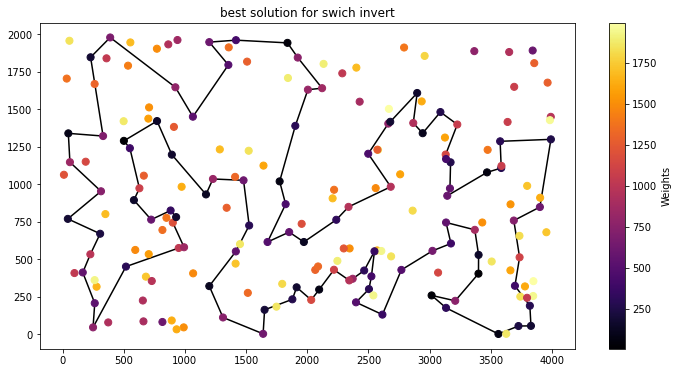

scores:  69464 69806.7 70485
[52, 55, 185, 40, 119, 165, 90, 81, 196, 31, 56, 113, 175, 171, 16, 44, 120, 25, 78, 145, 179, 57, 92, 129, 2, 152, 97, 1, 101, 75, 86, 26, 100, 121, 53, 180, 154, 135, 70, 127, 123, 112, 4, 84, 184, 190, 10, 177, 30, 54, 48, 160, 34, 181, 42, 43, 116, 65, 149, 162, 151, 51, 118, 59, 115, 46, 68, 139, 41, 193, 159, 22, 18, 108, 140, 93, 117, 0, 143, 183, 89, 186, 23, 137, 176, 80, 133, 79, 63, 94, 124, 148, 9, 62, 144, 102, 49, 14, 178, 106]
execution time: 25.000030279159546 25.005219912528993 25.010666131973267
ils iterations:  2701 2766.8 2845


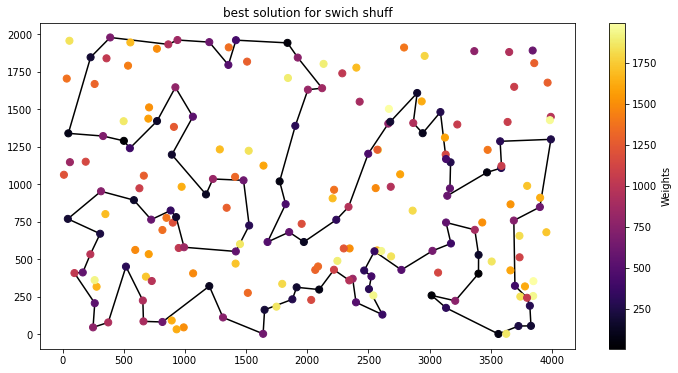

scores:  70042 70817.4 71620
[10, 190, 184, 84, 4, 112, 123, 127, 70, 135, 154, 180, 53, 100, 26, 86, 75, 101, 1, 97, 152, 2, 129, 92, 120, 44, 25, 16, 171, 175, 113, 56, 31, 78, 145, 196, 81, 90, 165, 119, 40, 185, 57, 55, 52, 106, 178, 49, 14, 144, 102, 62, 9, 148, 15, 186, 89, 183, 23, 137, 176, 80, 94, 63, 79, 133, 162, 151, 51, 118, 59, 65, 116, 43, 42, 5, 41, 193, 159, 139, 115, 46, 68, 0, 143, 117, 93, 140, 108, 69, 18, 22, 146, 195, 181, 34, 160, 48, 54, 177]
execution time: 25.000054597854614 25.002277207374572 25.006804943084717
ils iterations:  5578 5794.35 6094


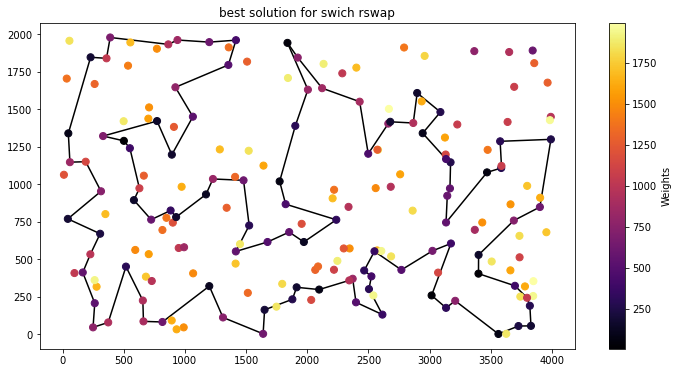

scores:  69311 69733.6 70093
[139, 41, 193, 159, 108, 18, 22, 146, 181, 34, 160, 48, 54, 177, 10, 190, 4, 112, 84, 184, 42, 43, 116, 65, 131, 149, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 100, 26, 86, 75, 101, 1, 97, 152, 2, 120, 44, 25, 16, 171, 175, 113, 56, 31, 78, 145, 92, 129, 57, 179, 196, 81, 90, 165, 119, 40, 185, 55, 52, 106, 178, 3, 49, 14, 144, 62, 9, 148, 124, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 140, 68, 46, 115]
execution time: 25.00053095817566 25.00461241006851 25.008779764175415
ils iterations:  2798 3007.25 3054


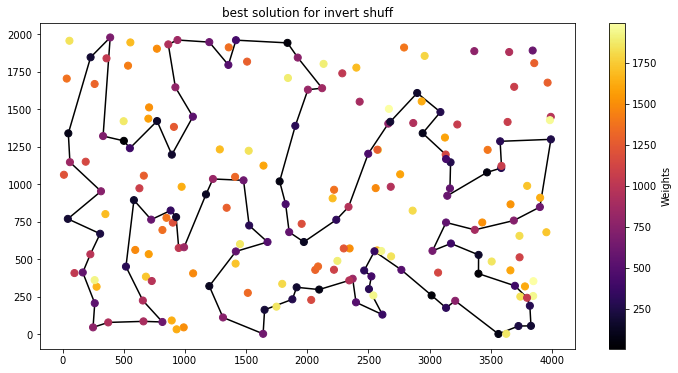

scores:  69809 70394.95 71267
[92, 145, 78, 31, 113, 175, 171, 16, 25, 44, 120, 2, 152, 97, 1, 101, 75, 86, 26, 53, 180, 154, 135, 70, 127, 123, 162, 151, 133, 79, 63, 94, 80, 176, 51, 118, 59, 149, 131, 65, 116, 43, 184, 84, 112, 4, 10, 177, 54, 48, 160, 34, 181, 42, 5, 115, 46, 68, 139, 41, 193, 159, 146, 22, 18, 108, 140, 93, 117, 0, 143, 183, 89, 23, 137, 186, 114, 15, 148, 9, 62, 102, 144, 14, 49, 3, 178, 106, 52, 55, 185, 40, 119, 165, 90, 81, 196, 179, 57, 129]
execution time: 25.000273942947388 25.00235961675644 25.004169464111328
ils iterations:  5836 5974.4 6068


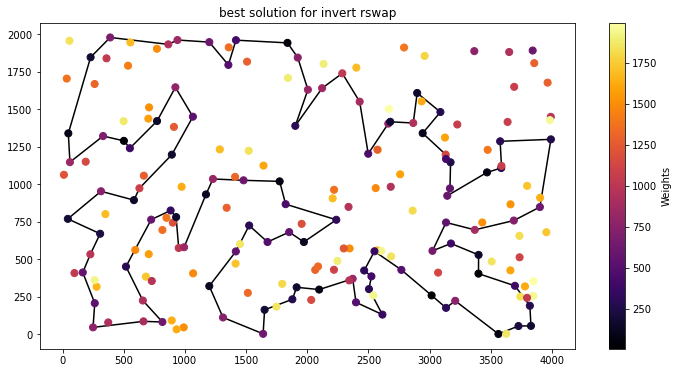

scores:  69413 69803.5 70410
[151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 121, 100, 26, 86, 75, 101, 1, 97, 152, 2, 120, 44, 25, 16, 171, 175, 113, 56, 31, 196, 81, 90, 165, 40, 185, 179, 145, 78, 92, 129, 57, 55, 52, 106, 178, 49, 14, 144, 102, 62, 9, 148, 124, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 68, 46, 115, 139, 41, 193, 159, 69, 108, 18, 22, 146, 181, 34, 160, 48, 54, 177, 10, 190, 4, 112, 84, 35, 184, 42, 43, 116, 65, 131, 149, 59, 118, 51]
execution time: 25.001031637191772 25.004966962337495 25.008850574493408
ils iterations:  2565 2605.2 2633


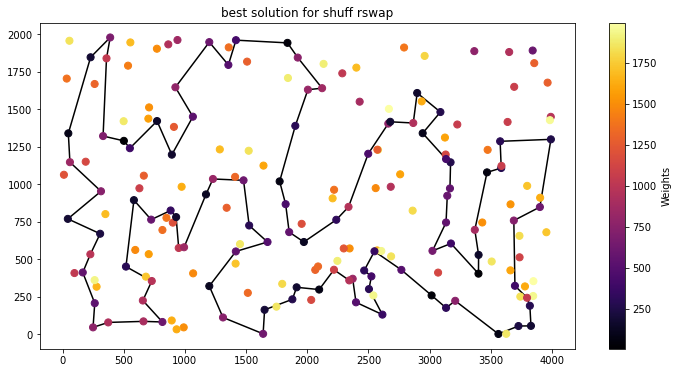

scores:  69239 69824.8 70126
[69, 68, 46, 115, 139, 41, 193, 159, 22, 146, 181, 34, 160, 48, 54, 177, 10, 190, 4, 112, 84, 184, 42, 43, 116, 65, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 100, 26, 86, 75, 101, 1, 97, 152, 2, 120, 44, 25, 129, 92, 57, 179, 145, 78, 16, 171, 175, 113, 56, 31, 196, 81, 90, 165, 119, 40, 185, 55, 52, 106, 178, 3, 14, 49, 102, 144, 62, 9, 148, 124, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 140, 108, 18]
execution time: 25.0009548664093 25.00505609512329 25.008841037750244
ils iterations:  2483 2522.55 2567


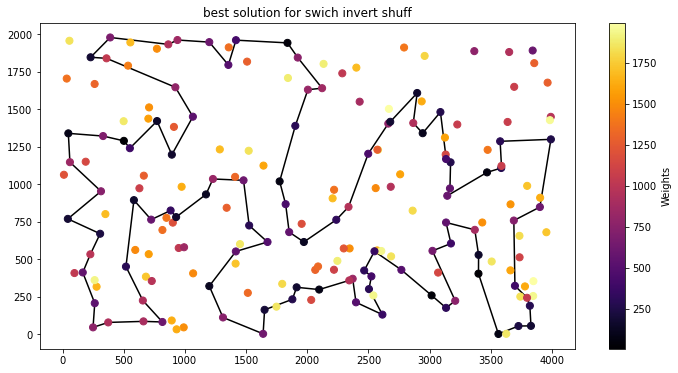

scores:  69887 70421.15 71085
[31, 78, 145, 92, 129, 57, 55, 52, 178, 106, 185, 119, 40, 196, 81, 90, 165, 138, 14, 144, 49, 102, 62, 9, 148, 167, 124, 94, 63, 79, 133, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 68, 46, 115, 139, 41, 193, 159, 69, 108, 18, 22, 146, 181, 34, 160, 48, 54, 177, 10, 4, 112, 84, 184, 42, 43, 116, 65, 131, 149, 59, 118, 51, 151, 162, 123, 127, 70, 135, 154, 180, 53, 121, 100, 26, 86, 75, 101, 1, 97, 152, 2, 120, 44, 25, 16, 171, 175, 113]
execution time: 25.000134706497192 25.002437627315523 25.005634307861328
ils iterations:  4648 4704.7 4822


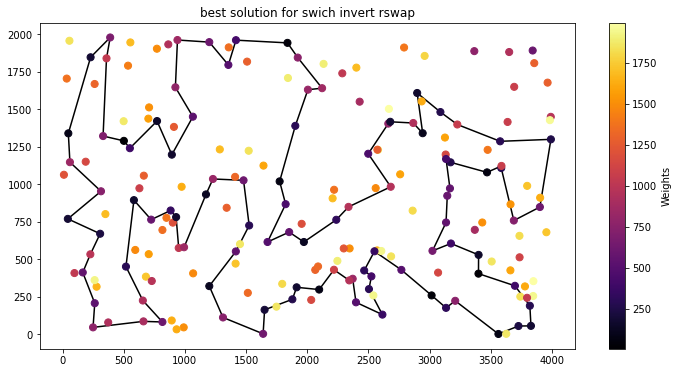

scores:  69591 69843.2 70154
[4, 190, 10, 177, 54, 160, 34, 181, 42, 43, 65, 116, 115, 46, 139, 41, 193, 159, 22, 18, 69, 108, 140, 93, 117, 0, 143, 183, 89, 186, 23, 137, 176, 80, 79, 63, 94, 124, 167, 148, 9, 62, 102, 49, 144, 14, 178, 106, 52, 55, 185, 40, 119, 165, 90, 81, 196, 179, 57, 129, 92, 145, 78, 31, 56, 113, 175, 171, 16, 25, 44, 120, 2, 152, 97, 1, 101, 75, 86, 26, 100, 53, 180, 154, 135, 70, 127, 123, 162, 133, 151, 51, 118, 59, 149, 131, 35, 184, 84, 112]
execution time: 25.00113582611084 25.005718648433685 25.010921955108643
ils iterations:  2127 2301.7 2362


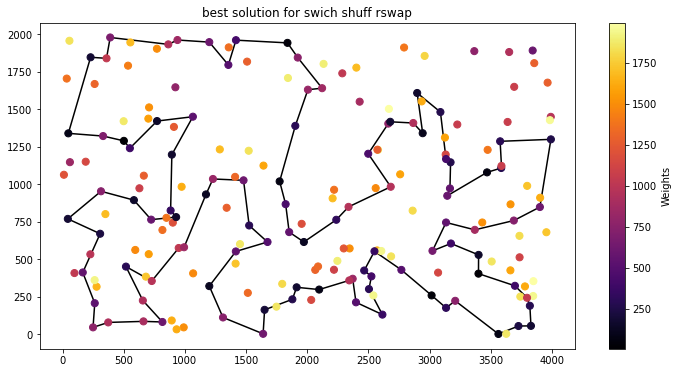

scores:  69323 69794.75 70124
[151, 133, 162, 123, 127, 70, 135, 154, 180, 53, 100, 26, 86, 75, 101, 1, 97, 152, 2, 120, 44, 25, 16, 171, 175, 113, 56, 31, 196, 81, 90, 165, 119, 40, 185, 179, 145, 78, 92, 129, 57, 55, 52, 106, 178, 49, 14, 144, 62, 9, 148, 124, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 140, 108, 69, 18, 22, 146, 34, 160, 48, 54, 177, 10, 190, 4, 112, 84, 184, 131, 149, 65, 116, 43, 42, 181, 159, 193, 41, 115, 139, 68, 46, 118, 59, 51]
execution time: 25.000661611557007 25.006795728206633 25.01223659515381
ils iterations:  2275 2316.6 2354


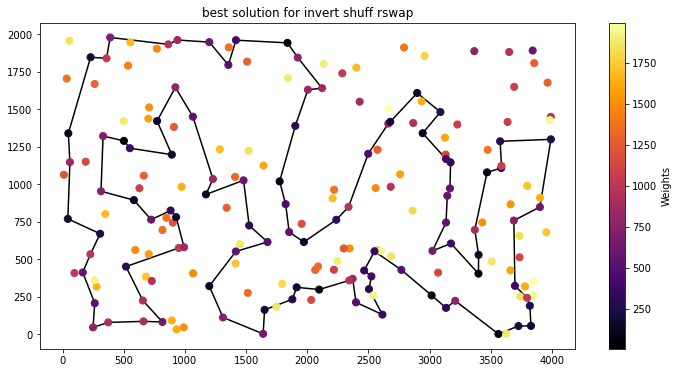

scores:  69530 69881.65 70520
[121, 53, 180, 154, 135, 70, 127, 123, 162, 133, 151, 51, 118, 59, 149, 131, 65, 116, 43, 184, 84, 112, 4, 10, 177, 54, 48, 160, 34, 181, 42, 5, 115, 46, 68, 139, 41, 193, 159, 146, 22, 18, 108, 140, 93, 117, 0, 143, 183, 89, 186, 23, 137, 176, 80, 79, 63, 94, 124, 148, 9, 62, 144, 14, 49, 178, 106, 52, 55, 185, 40, 119, 165, 90, 81, 196, 31, 56, 113, 175, 171, 16, 78, 145, 179, 57, 92, 129, 25, 44, 120, 2, 152, 97, 1, 101, 75, 86, 26, 100]
execution time: 25.000412464141846 25.00527466535568 25.01313281059265
ils iterations:  2057 2201.8 2273


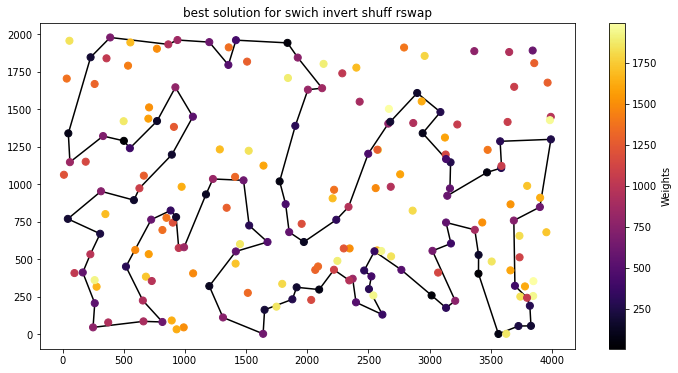

In [63]:
for combination in all_combinations:
    test_method(neighborhood, dist, costs, coordinates, pert_f=combination, name=' '.join([x.__name__ for x in combination]))

In [68]:
n = 200
interNeighborhood = InterNeighborhood(distb, costsb, n // 2)
edgeNeighborhood = EdgeNeighborhood(distb, costsb, n // 2)
neighborhood = CombinedNeighborhood([edgeNeighborhood, interNeighborhood])

scores:  44865 45686.8 46240
[104, 8, 21, 82, 111, 144, 33, 160, 29, 0, 109, 35, 143, 106, 124, 62, 18, 55, 34, 170, 152, 183, 140, 28, 20, 148, 47, 94, 66, 179, 22, 99, 130, 95, 185, 86, 166, 194, 176, 113, 114, 137, 127, 89, 103, 163, 153, 81, 77, 141, 61, 36, 177, 5, 78, 175, 45, 162, 80, 190, 136, 73, 164, 31, 54, 193, 117, 198, 156, 27, 38, 1, 121, 51, 191, 90, 122, 135, 63, 100, 40, 107, 133, 10, 147, 6, 188, 169, 132, 13, 70, 3, 145, 195, 168, 43, 139, 11, 182, 138]
execution time: 23.493191957473755 25.701728844642638 30.163586854934692


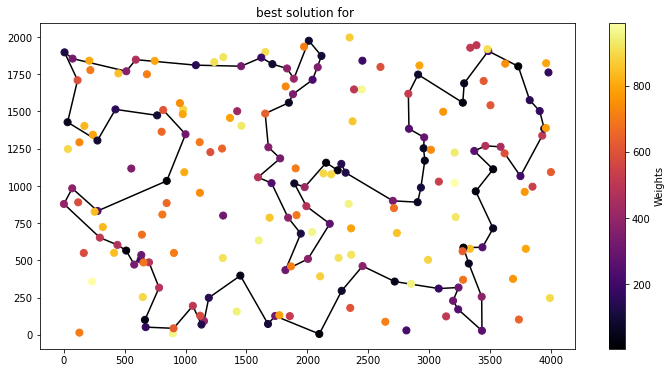

scores:  46420 47971.55 50309
[33, 144, 104, 8, 111, 81, 77, 141, 36, 61, 21, 177, 5, 78, 175, 80, 190, 193, 31, 54, 117, 198, 156, 27, 38, 16, 1, 131, 135, 63, 40, 107, 10, 133, 122, 90, 121, 51, 188, 169, 132, 13, 126, 168, 195, 145, 15, 70, 3, 155, 184, 152, 170, 34, 55, 18, 62, 124, 106, 128, 95, 130, 183, 140, 149, 28, 20, 60, 148, 47, 94, 66, 172, 179, 185, 86, 166, 194, 176, 113, 103, 163, 89, 127, 137, 165, 187, 146, 153, 159, 143, 35, 109, 0, 29, 160, 49, 11, 139, 138]
execution time: 25.000037670135498 25.001650834083556 25.002981424331665
ils iterations:  8380 8937.25 9243


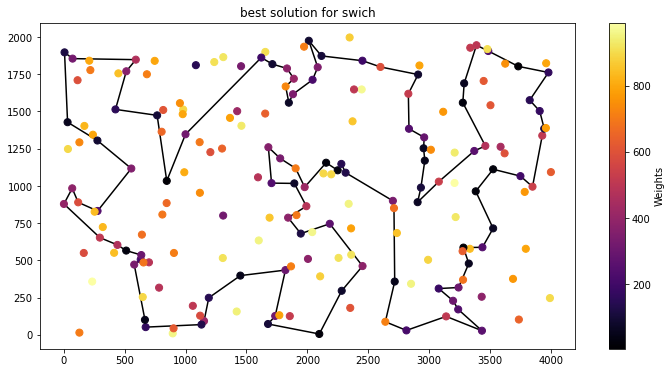

scores:  46221 47988.75 49872
[11, 139, 43, 168, 195, 13, 145, 15, 3, 70, 132, 169, 188, 6, 147, 51, 121, 131, 90, 122, 133, 10, 107, 40, 63, 135, 38, 27, 16, 1, 198, 117, 54, 73, 31, 193, 190, 80, 175, 78, 142, 5, 177, 36, 61, 79, 91, 141, 77, 81, 153, 187, 163, 89, 127, 103, 113, 176, 194, 166, 179, 94, 47, 148, 20, 28, 140, 183, 95, 185, 86, 128, 124, 106, 143, 62, 18, 55, 34, 170, 152, 155, 189, 69, 29, 12, 0, 109, 35, 41, 111, 82, 21, 8, 104, 144, 160, 33, 138, 182]
execution time: 25.000033140182495 25.001561188697814 25.003352403640747
ils iterations:  8926 9064.9 9216


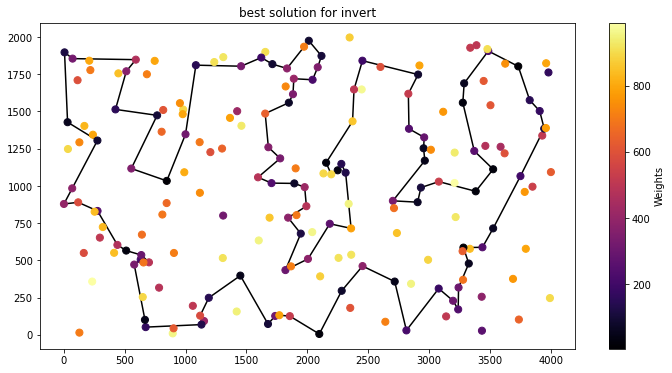

scores:  43849 44420.2 44887
[18, 55, 34, 170, 152, 183, 140, 149, 28, 20, 60, 148, 47, 94, 66, 179, 185, 99, 130, 95, 86, 166, 194, 176, 113, 114, 137, 127, 89, 103, 163, 153, 81, 77, 141, 91, 61, 36, 177, 5, 142, 78, 175, 80, 190, 136, 73, 54, 31, 193, 117, 198, 156, 1, 27, 38, 63, 40, 107, 133, 122, 135, 131, 121, 51, 125, 90, 191, 147, 6, 188, 169, 132, 13, 70, 3, 15, 145, 195, 168, 139, 11, 138, 33, 160, 144, 104, 8, 21, 82, 111, 29, 0, 109, 35, 143, 159, 106, 124, 62]
execution time: 25.0006582736969 25.005490469932557 25.011144638061523
ils iterations:  2423 2744.05 2982


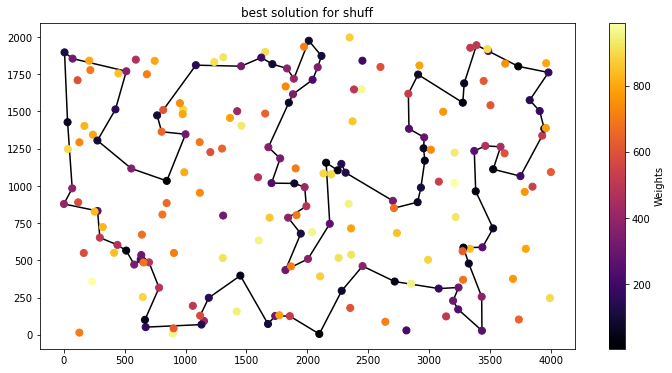

scores:  45808 47458.3 48744
[38, 102, 63, 100, 40, 107, 10, 133, 122, 135, 131, 121, 51, 90, 191, 71, 147, 134, 6, 188, 169, 132, 70, 3, 15, 145, 13, 195, 168, 139, 11, 138, 33, 160, 29, 0, 109, 35, 143, 159, 106, 124, 128, 62, 18, 55, 34, 152, 183, 140, 4, 149, 28, 20, 148, 47, 94, 179, 185, 130, 95, 86, 166, 194, 176, 180, 113, 163, 89, 103, 114, 137, 127, 165, 187, 153, 81, 77, 82, 111, 144, 56, 104, 8, 21, 61, 36, 177, 5, 175, 80, 190, 31, 54, 117, 198, 156, 1, 16, 27]
execution time: 25.00000834465027 25.001547980308533 25.00305151939392
ils iterations:  6805 7034.45 7223


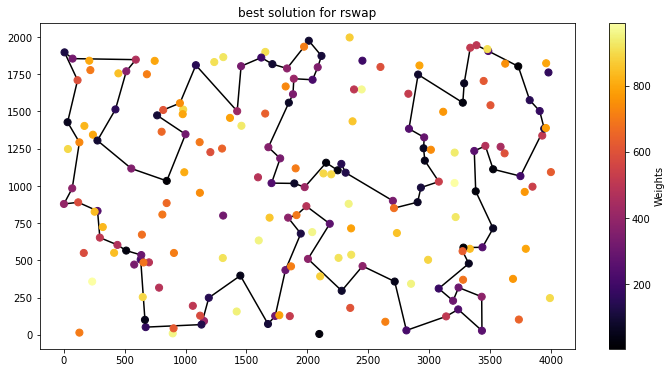

scores:  44583 45924.35 48776
[195, 168, 11, 138, 104, 8, 21, 87, 82, 111, 160, 33, 29, 0, 109, 35, 143, 106, 124, 62, 18, 55, 34, 170, 152, 183, 140, 28, 20, 60, 148, 47, 94, 66, 179, 185, 130, 95, 86, 166, 194, 176, 113, 103, 114, 137, 127, 165, 89, 163, 153, 81, 77, 141, 61, 36, 177, 5, 45, 142, 78, 175, 162, 80, 190, 136, 73, 164, 54, 31, 193, 117, 198, 156, 1, 27, 38, 131, 121, 51, 90, 122, 135, 63, 100, 40, 107, 133, 10, 147, 134, 6, 188, 169, 132, 70, 3, 15, 145, 13]
execution time: 25.00036644935608 25.00210392475128 25.00390601158142
ils iterations:  6688 6840.1 6971


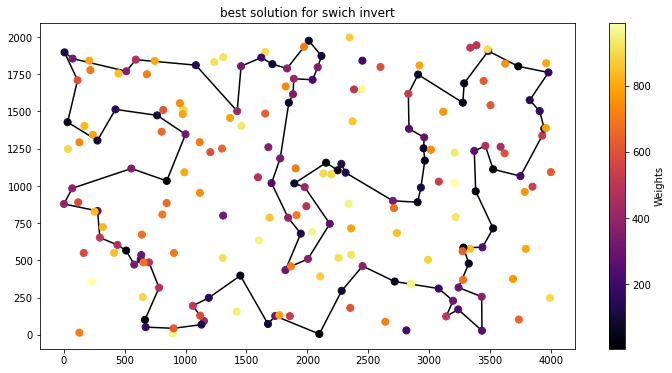

scores:  43637 44253.25 44858
[133, 122, 135, 131, 121, 51, 90, 191, 147, 6, 188, 169, 132, 13, 70, 3, 15, 145, 195, 168, 139, 11, 138, 33, 160, 144, 104, 8, 82, 111, 29, 0, 109, 35, 143, 106, 124, 62, 18, 55, 34, 152, 183, 140, 4, 149, 28, 20, 60, 148, 47, 94, 66, 179, 99, 130, 95, 185, 86, 166, 194, 176, 113, 114, 137, 127, 89, 103, 163, 153, 81, 77, 141, 91, 61, 36, 177, 5, 45, 142, 78, 175, 162, 80, 190, 136, 73, 54, 31, 193, 117, 198, 156, 1, 16, 27, 38, 63, 40, 107]
execution time: 25.000380039215088 25.006171786785124 25.01217246055603
ils iterations:  2329 2619.75 2839


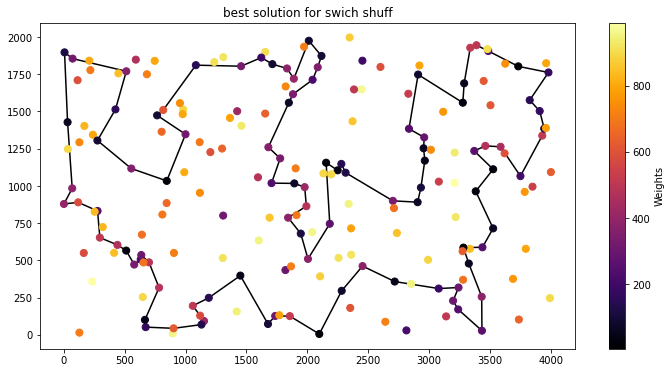

scores:  44520 45365.45 46268
[35, 143, 106, 124, 62, 18, 55, 34, 170, 155, 184, 152, 183, 140, 149, 28, 20, 60, 148, 47, 94, 179, 185, 95, 86, 166, 194, 176, 113, 103, 127, 89, 163, 153, 81, 77, 141, 91, 61, 36, 177, 5, 78, 175, 142, 45, 162, 80, 190, 136, 73, 54, 31, 193, 117, 198, 156, 1, 16, 27, 38, 135, 63, 100, 40, 107, 10, 133, 122, 131, 121, 51, 90, 191, 147, 6, 188, 169, 132, 70, 3, 15, 145, 195, 168, 139, 11, 182, 138, 33, 160, 144, 104, 21, 82, 8, 111, 29, 0, 109]
execution time: 25.000382661819458 25.00230827331543 25.00458836555481
ils iterations:  5140 5310.25 5382


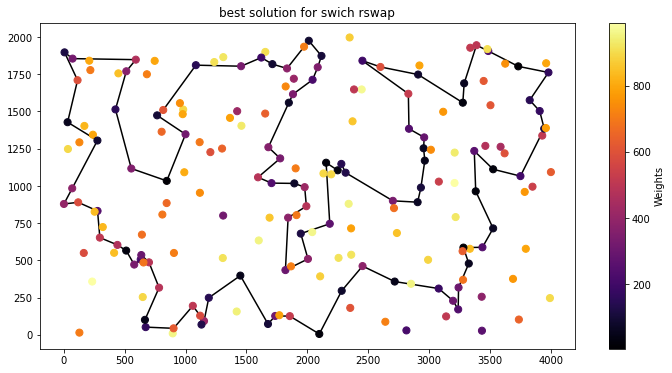

scores:  43834 44320.85 44762
[81, 153, 163, 103, 89, 165, 127, 137, 114, 113, 180, 176, 194, 166, 86, 185, 95, 130, 99, 179, 66, 94, 47, 148, 60, 20, 28, 149, 140, 183, 152, 170, 34, 55, 18, 62, 124, 106, 143, 35, 109, 0, 29, 160, 33, 144, 111, 8, 104, 138, 11, 139, 168, 195, 145, 15, 3, 70, 13, 132, 169, 188, 6, 147, 90, 51, 121, 131, 135, 122, 133, 10, 107, 40, 63, 38, 27, 16, 1, 156, 198, 117, 193, 31, 54, 73, 136, 190, 80, 175, 78, 142, 5, 177, 21, 61, 36, 91, 141, 77]
execution time: 25.000184774398804 25.004324328899383 25.00954842567444
ils iterations:  2551 2630.05 2709


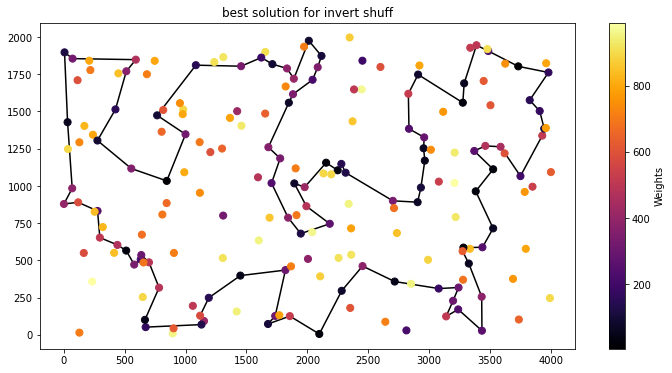

scores:  44342 45207.95 46332
[104, 138, 11, 139, 168, 195, 13, 145, 15, 3, 70, 132, 169, 188, 6, 134, 147, 191, 90, 125, 51, 121, 131, 135, 122, 133, 10, 107, 40, 63, 38, 27, 16, 1, 156, 198, 117, 193, 31, 54, 73, 136, 190, 80, 45, 142, 175, 78, 5, 177, 21, 61, 36, 91, 141, 77, 81, 153, 187, 163, 89, 127, 103, 113, 176, 194, 166, 86, 185, 95, 130, 99, 22, 179, 66, 94, 47, 148, 60, 20, 28, 149, 4, 140, 183, 152, 170, 34, 55, 18, 62, 124, 106, 35, 109, 0, 29, 160, 33, 8]
execution time: 25.000935554504395 25.002690935134886 25.00719428062439
ils iterations:  5579 5900.85 6244


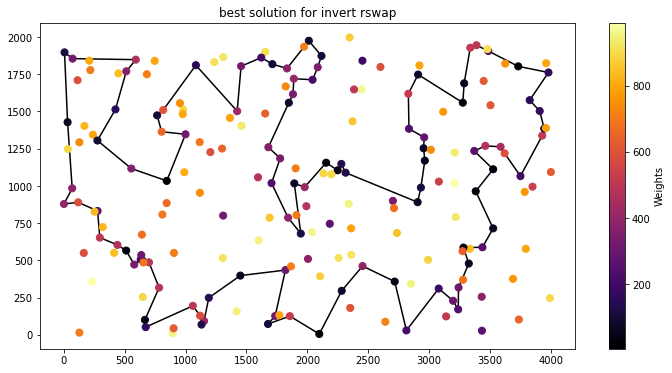

scores:  43968 44423.85 44886
[185, 86, 166, 194, 176, 180, 113, 26, 103, 114, 137, 127, 165, 89, 163, 153, 81, 77, 141, 91, 61, 36, 177, 5, 78, 175, 45, 80, 190, 73, 54, 31, 193, 117, 198, 156, 1, 27, 38, 63, 40, 107, 122, 135, 131, 121, 51, 90, 191, 147, 6, 188, 169, 132, 70, 3, 15, 145, 13, 195, 168, 139, 11, 138, 104, 8, 21, 82, 111, 144, 33, 160, 29, 0, 109, 35, 143, 106, 124, 62, 18, 55, 34, 170, 152, 183, 140, 28, 20, 60, 148, 47, 94, 66, 172, 179, 22, 99, 130, 95]
execution time: 25.00028944015503 25.00385127067566 25.009535551071167
ils iterations:  2499 2665.75 2772


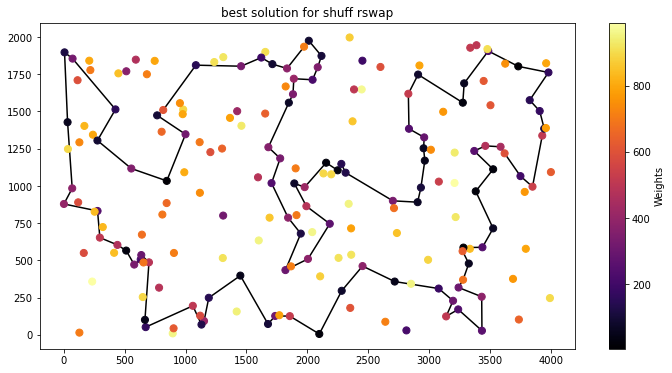

scores:  43967 44306.6 44746
[109, 0, 29, 160, 33, 144, 111, 8, 104, 138, 11, 139, 168, 195, 13, 145, 15, 3, 70, 132, 169, 188, 6, 147, 10, 133, 107, 40, 100, 63, 135, 122, 90, 191, 125, 51, 121, 131, 1, 156, 198, 117, 193, 31, 54, 73, 136, 190, 80, 45, 142, 175, 78, 5, 177, 36, 61, 91, 141, 77, 81, 153, 187, 163, 103, 89, 127, 114, 113, 176, 194, 166, 86, 185, 95, 130, 99, 22, 179, 66, 94, 47, 148, 60, 20, 28, 149, 4, 140, 183, 152, 34, 55, 18, 62, 124, 106, 159, 143, 35]
execution time: 25.000149488449097 25.004711353778838 25.009972095489502
ils iterations:  2589 2731.65 2785


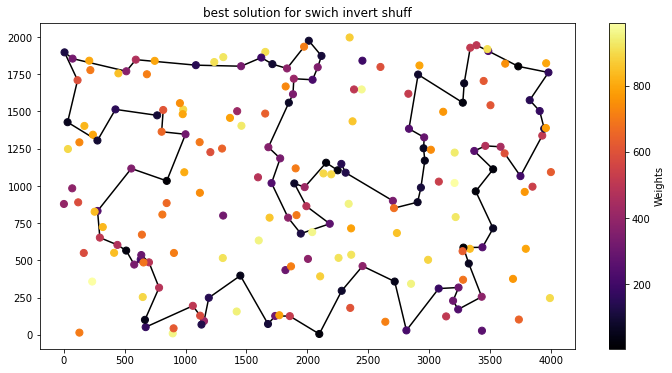

scores:  44139 44971.7 45713
[137, 114, 113, 180, 176, 194, 166, 86, 185, 95, 130, 99, 22, 179, 66, 94, 47, 148, 60, 20, 28, 140, 183, 152, 170, 34, 55, 18, 62, 124, 106, 159, 143, 35, 109, 0, 29, 160, 33, 138, 11, 139, 168, 195, 13, 145, 15, 3, 70, 132, 169, 188, 6, 147, 191, 90, 125, 51, 121, 131, 122, 135, 63, 38, 27, 16, 1, 156, 198, 117, 193, 31, 54, 73, 136, 190, 80, 175, 78, 142, 45, 5, 177, 36, 61, 21, 8, 104, 144, 111, 82, 141, 77, 81, 153, 187, 163, 103, 89, 127]
execution time: 25.000060558319092 25.002546775341035 25.00512194633484
ils iterations:  5076 5118.2 5157


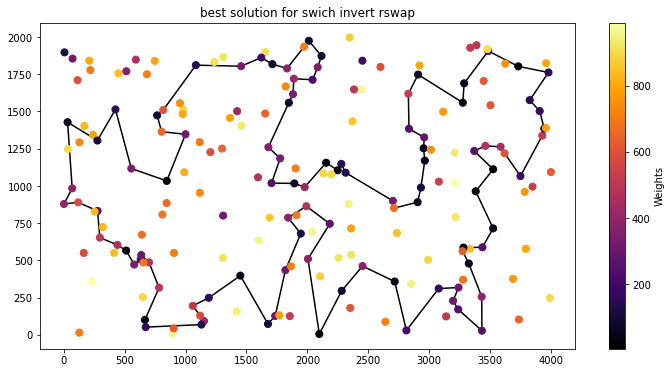

scores:  43787 44391.2 44775
[113, 180, 176, 194, 166, 86, 95, 130, 99, 185, 179, 66, 94, 47, 148, 60, 20, 28, 149, 4, 140, 183, 152, 34, 55, 18, 62, 124, 106, 143, 35, 109, 0, 29, 111, 8, 104, 144, 160, 33, 138, 182, 11, 139, 168, 195, 145, 15, 3, 70, 13, 132, 169, 188, 6, 147, 90, 51, 121, 131, 135, 122, 133, 107, 40, 63, 38, 27, 16, 1, 156, 198, 117, 193, 31, 54, 73, 136, 190, 80, 45, 142, 175, 78, 5, 177, 21, 61, 36, 91, 141, 77, 81, 153, 187, 163, 103, 89, 127, 114]
execution time: 25.00097346305847 25.006053149700165 25.011155605316162
ils iterations:  2478 2507.55 2535


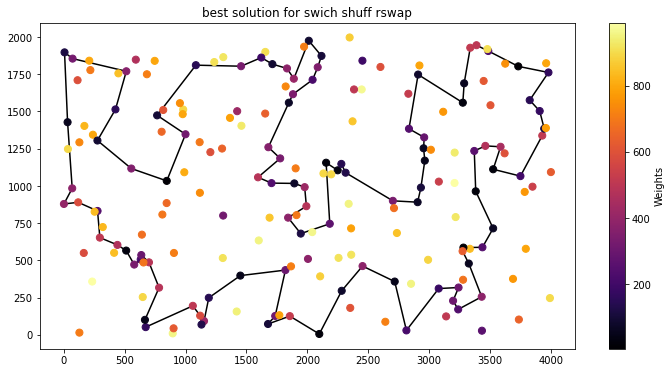

scores:  43721 44248.7 44844
[170, 34, 55, 18, 62, 124, 106, 143, 35, 109, 0, 29, 111, 8, 104, 144, 160, 33, 138, 11, 139, 168, 195, 13, 145, 15, 3, 70, 132, 169, 188, 6, 147, 90, 51, 121, 131, 135, 122, 133, 10, 107, 40, 63, 38, 27, 16, 1, 156, 198, 117, 193, 54, 31, 164, 73, 136, 190, 80, 175, 78, 5, 177, 21, 61, 36, 91, 141, 77, 81, 153, 187, 165, 127, 89, 163, 103, 113, 176, 194, 166, 86, 185, 95, 130, 99, 22, 179, 66, 94, 47, 148, 60, 20, 28, 149, 4, 140, 183, 152]
execution time: 25.000132083892822 25.005078303813935 25.0098135471344
ils iterations:  2506 2527.65 2553


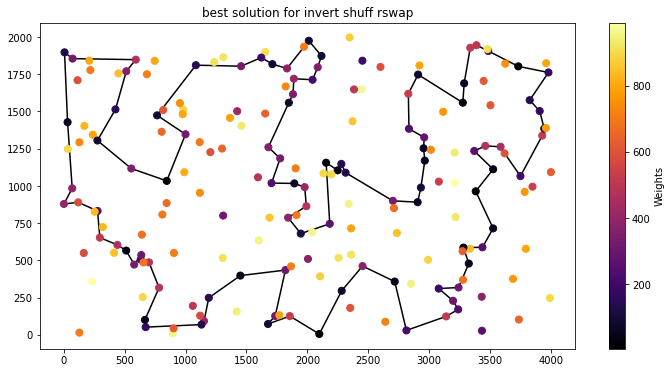

scores:  43893 44287.15 44832
[47, 148, 60, 20, 28, 149, 4, 140, 183, 152, 170, 34, 55, 18, 62, 124, 106, 143, 35, 109, 0, 29, 160, 33, 144, 111, 82, 8, 104, 138, 11, 139, 168, 195, 145, 15, 3, 70, 13, 132, 169, 188, 6, 147, 51, 90, 122, 133, 107, 40, 63, 135, 38, 27, 1, 156, 198, 117, 193, 54, 31, 164, 73, 136, 190, 80, 45, 142, 175, 78, 5, 177, 36, 61, 91, 141, 77, 81, 153, 187, 163, 89, 127, 137, 114, 103, 26, 113, 176, 194, 166, 86, 185, 95, 130, 99, 22, 179, 66, 94]
execution time: 25.000848293304443 25.00472549200058 25.01114010810852
ils iterations:  2283 2301.7 2320


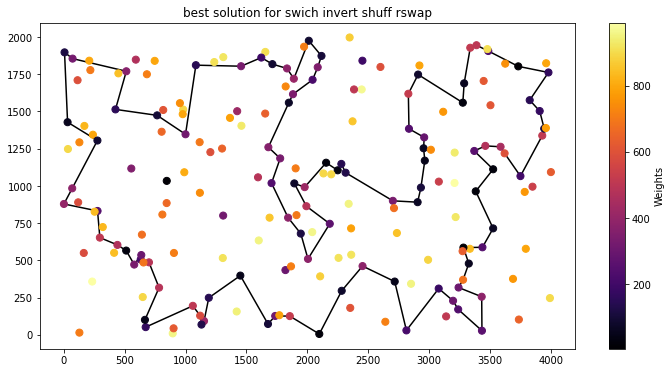

In [69]:
for combination in all_combinations:
    test_method(neighborhood, distb, costsb, coordinatesb, pert_f=combination, name=' '.join([x.__name__ for x in combination]))